In [1]:
import numpy as np
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, shape=(None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        return out
    
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.layers.dense(h1, 1,activation=None)
        out = tf.sigmoid(logits)
        return out, logits
    

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Size of input image to discriminator
input_size = 784
# Size of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Smoothing 
smooth = 0.1

tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

In [4]:
g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

# calculate losses
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                    labels=tf.ones_like(d_logits_real)*(1-smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
# Optimizers

learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [5]:
batch_size = 100
epochs = 300
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
        
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.3523... Generator Loss: 3.9898
Epoch 2/300... Discriminator Loss: 0.3870... Generator Loss: 3.5480
Epoch 3/300... Discriminator Loss: 0.6675... Generator Loss: 3.4257
Epoch 4/300... Discriminator Loss: 0.9579... Generator Loss: 7.0271
Epoch 5/300... Discriminator Loss: 0.9324... Generator Loss: 3.3580
Epoch 6/300... Discriminator Loss: 0.9802... Generator Loss: 2.3199
Epoch 7/300... Discriminator Loss: 1.5288... Generator Loss: 1.4223
Epoch 8/300... Discriminator Loss: 3.0623... Generator Loss: 2.0874
Epoch 9/300... Discriminator Loss: 1.9756... Generator Loss: 0.9451
Epoch 10/300... Discriminator Loss: 1.2588... Generator Loss: 2.4617
Epoch 11/300... Discriminator Loss: 1.8678... Generator Loss: 1.8748
Epoch 12/300... Discriminator Loss: 1.7818... Generator Loss: 1.4107
Epoch 13/300... Discriminator Loss: 1.2198... Generator Loss: 1.5438
Epoch 14/300... Discriminator Loss: 1.8919... Generator Loss: 1.9387
Epoch 15/300... Discriminator Loss: 1.1025.

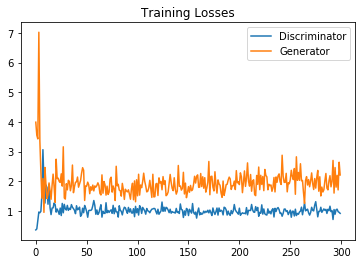

In [6]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [7]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

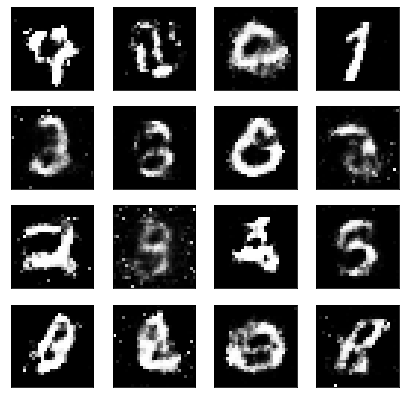

In [17]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

_ = view_samples(-1, samples)

INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt
(16, 784)
(1, 16, 784)


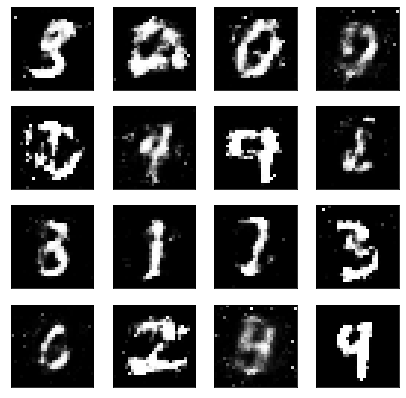

In [32]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(
                    generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                    feed_dict={input_z: sample_z})
print(gen_samples.shape)
gen_samples = gen_samples.reshape(1, 16, 784)
print(gen_samples.shape)
_ = view_samples(0, gen_samples)
    